In [1]:
import pickle

data_to_load = {
    "X_test": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_test = data_to_load["X_test"]
y_test = data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:

"""
from tensorflow.keras import models

model = models.load_model('lstm')
model.summary()
"""

import scutquant.scutquant as q
model1 = q.hybrid(weight=[0, 1])
model1.load("./hybrid")


with open("lgbm/lgbm.pkl", "rb") as file:
    model2 = pickle.load(file)
    file.close()

将xgboost和lightGBM按照3:7混合

In [3]:
import pandas as pd

"""
pred = model.predict(X_test)
"""

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)

def ensemble(pred1, pred2, weight=[0.5, 0.5]):
    pred = []
    for i in range(len(pred1)):
        pred.append(weight[0] * pred1[i] + weight[1] * pred2[i])
    return pred

pred = ensemble(pred1, pred2, weight=[0.3, 0.7])
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

,predict
count,281840.000000
mean,-0.000171
std,0.001770
min,-0.030902
25%,-0.000867
50%,0.000033
75%,0.000791
max,0.031542


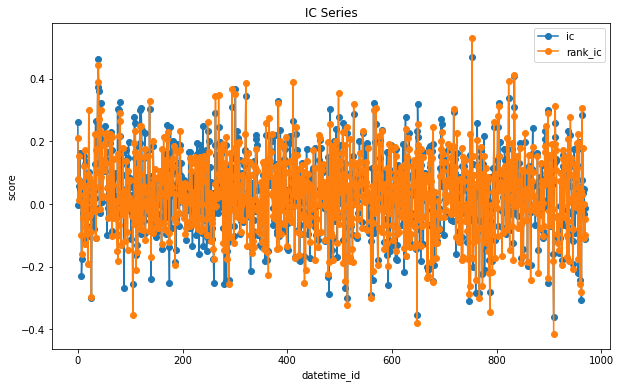

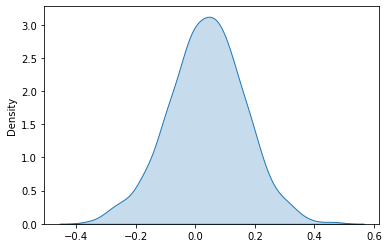

ic= 0.036321379328515355 icir= 0.28535225264675934 rank_ic= 0.032995386414470064 rank_icir= 0.25829326744881764


0.03248212354203683

In [4]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

In [5]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')

In [6]:
pred

predict       price     volume
time       code                                      
2019-01-02 000001.SZ  0.000769    9.252048  539386.32
           000002.SZ -0.000716   24.120738  247010.28
           000063.SZ -0.002223   19.088275  649682.72
           000069.SZ -0.002177    5.999183  403924.79
           000100.SZ -0.001105    2.515065  890514.27
...                        ...         ...        ...
2022-12-27 688363.SH -0.003939  136.312691   67620.51
           688396.SH  0.000342   53.127821   22894.05
           688561.SH -0.000144   65.791178   17585.16
           688599.SH -0.001871   62.192181  170829.80
           688981.SH -0.000075   41.078327   61293.26

[281386 rows x 3 columns]

In [7]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 每天做多预测值大于mean + n*sigam的股票, 做空预测值小于mean - n*sigma的股票
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,  # 为0时，只能用底仓做空；>0 时, 融券做空
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.55  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "cost": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, cost = backtest["generator"], backtest["strategy"], backtest["account"], backtest["cost"]
exe = executor.Executor(generator, strategy, account, cost)
exe.execute(data=pred, verbose=0)

E(r): 0.6658532964690953
std: 0.3537547473856174
E(r_benchmark): 0.4145573363202267
std_benchmark: 0.1728743456410088 

Cumulative Rate of Return: 1.1392513330052827
Cumulative Rate of Return(benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.799665769969734 

Max Drawdown: -0.27927500761566537
Max Drawdown(benchmark): -0.5462600364770351 

Sharpe Ratio: 1.8820132015430915
Sortino Ratio: 3.0947349248814158
Information Ratio: 0.7103677392488488 

Beta: 1.497931554558506
Profitable Days(%): 0.8544891640866873


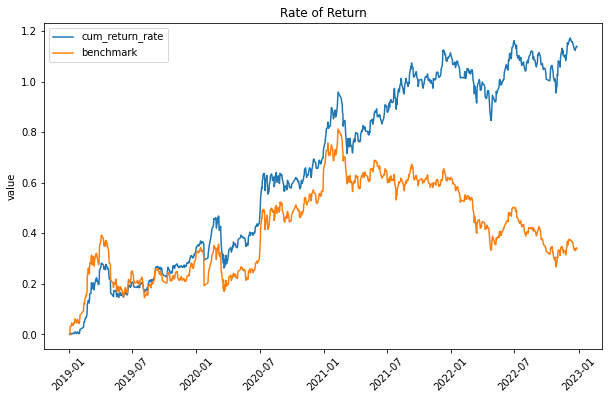

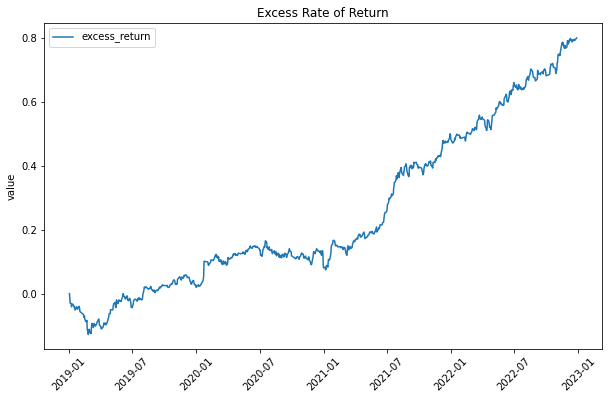

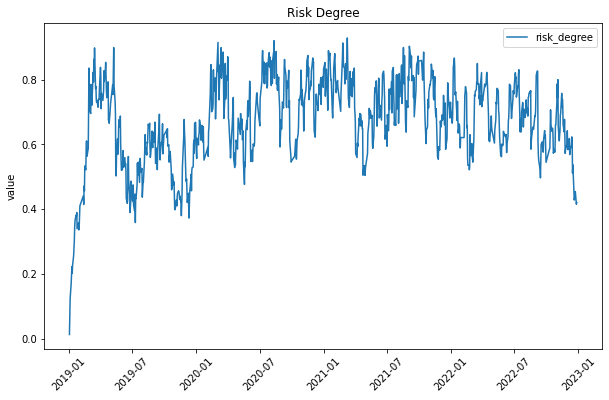

In [8]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [9]:
# user_account.position # 查看仓位